In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
import phys_utils as phys



In [11]:
CFG = phys.CFG
STRATEGY = CFG['simplex']['strategy']
TRAIN_FILE = CFG['files']['train']
TEST_FILE = CFG['files']['test']
DUMP_SIMPLEX = CFG['files']['dump_simplex']

# Expected Final Parameter File
PARAM_FILE = f"final_params_{STRATEGY}.txt"

In [12]:


def recover_best_from_dump(dump_file, output_file):
    """Recover best parameters if simplex crashed."""
    print(f"(!) {output_file} not found. Attempting recovery from {dump_file}...")
    if not os.path.exists(dump_file):
        exit(f"Critical Error: Neither {output_file} nor {dump_file} exists.")

    best_score = float('inf')
    best_params = None
    found_any = False

    with open(dump_file, 'r') as f:
        for line in f:
            if "|" not in line: continue
            try:
                parts = line.strip().split("|")
                score = float(parts[1])
                if score < best_score:
                    best_score = score
                    best_params = list(map(float, parts[0].split(",")))
                    found_any = True
            except ValueError: continue

    if found_any:
        print(f"    Recovered best score: {best_score:.4f}")
        np.savetxt(output_file, best_params)
    else:
        exit("Error: Could not parse dump file.")

def process_dataset(atoms_list, calculator):
    """Helper to evaluate a dataset and return arrays."""
    pred_e, targ_e = [], []
    pred_f, targ_f = [], []
    
    for atoms in atoms_list:
        # 1. Get Targets (pre-calculated)
        t_e = atoms.info.get('energy_dft', atoms.get_potential_energy()/len(atoms))
        t_f = atoms.info.get('forces_dft', atoms.get_forces().flatten())
        
        # 2. Get Predictions
        atoms.calc = calculator
        try:
            p_e = atoms.get_potential_energy() / len(atoms)
            p_f = atoms.get_forces().flatten()
        except:
            p_e, p_f = 1e9, np.zeros_like(t_f) # Handle crash

        pred_e.append(p_e)
        targ_e.append(t_e)
        pred_f.extend(p_f)
        targ_f.extend(t_f)
        
    return np.array(pred_e), np.array(targ_e), np.array(pred_f), np.array(targ_f)


--- STEP 4: Analysis (BALANCED) ---
Loaded parameters from final_params_balanced.txt
Loading Datasets...
Calculating predictions...
/global/cfs/cdirs/m3560/suvo/anaconda3/lib/python3.10/site-packages/lammps-2023.3.28-py3.10-linux-x86_64.egg/lammps/liblammps.so
Train Energy MAE: 42.19 meV/atom
Test Energy MAE:  85.85 meV/atom
Train Force MAE:  595.43 meV/A
Test Force MAE:   881.99 meV/A
Generating 2x2 Plots...
Analysis Complete. Saved plot to parity_plots_balanced_subplots.png


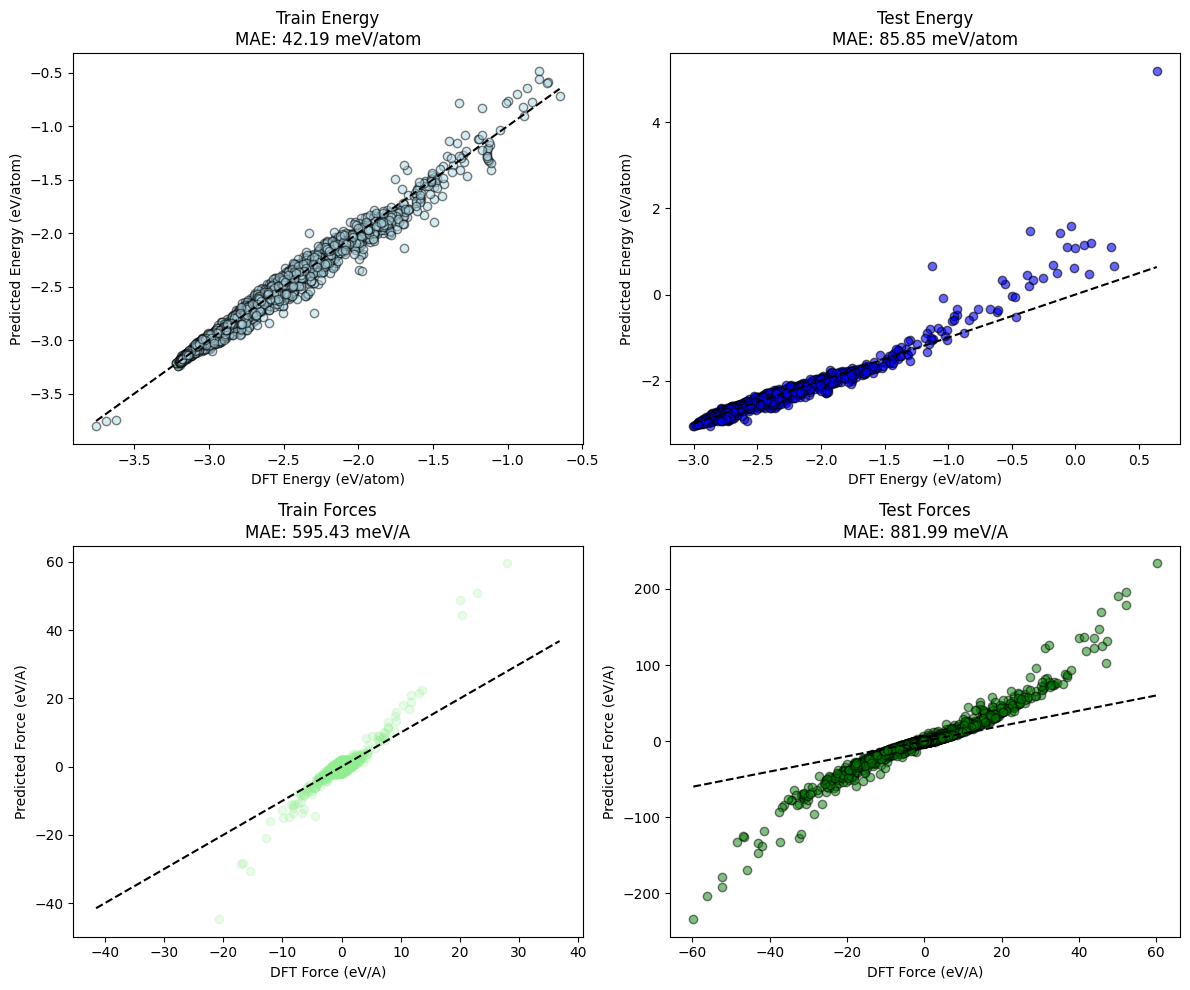

In [18]:
if __name__ == "__main__":
    print(f"--- STEP 4: Analysis ({STRATEGY.upper()}) ---")

    # --- RECOVERY LOGIC ---
    if not os.path.exists(PARAM_FILE):
        recover_best_from_dump(DUMP_SIMPLEX, PARAM_FILE)

    # --- LOADING ---
    try: 
        final_params = np.loadtxt(PARAM_FILE)
        print(f"Loaded parameters from {PARAM_FILE}")
    except: 
        exit(f"Error: Could not load {PARAM_FILE}.")

    print("Loading Datasets...")
    train_atoms = read(TRAIN_FILE, index=":")
    test_atoms = read(TEST_FILE, index=":")

    # Pre-calc DFT Refs for both
    for lst in [train_atoms, test_atoms]:
        for atoms in lst:
            atoms.info['energy_dft'] = atoms.get_potential_energy()/len(atoms)
            atoms.info['forces_dft'] = atoms.get_forces().flatten()

    print("Calculating predictions...")
    calc = phys.get_calculator(final_params)
    
    # Process both sets
    tr_pe, tr_te, tr_pf, tr_tf = process_dataset(train_atoms, calc)
    te_pe, te_te, te_pf, te_tf = process_dataset(test_atoms, calc)

    # --- CALCULATE METRICS (MAE) ---
    mae_e_tr = np.mean(np.abs(tr_te - tr_pe)) * 1000  # meV
    mae_e_te = np.mean(np.abs(te_te - te_pe)) * 1000  # meV
    mae_f_tr = np.mean(np.abs(tr_tf - tr_pf)) * 1000  # meV
    mae_f_te = np.mean(np.abs(te_tf - te_pf)) * 1000  # meV

    print(f"Train Energy MAE: {mae_e_tr:.2f} meV/atom")
    print(f"Test Energy MAE:  {mae_e_te:.2f} meV/atom")
    print(f"Train Force MAE:  {mae_f_tr:.2f} meV/A")
    print(f"Test Force MAE:   {mae_f_te:.2f} meV/A")

    print("Generating 2x2 Plots...")
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # --- ROW 1: ENERGY ---
    
    # Train Energy
    

    axs[0, 0].scatter(tr_te, tr_pe, alpha=0.5, c='lightblue', edgecolors='k')
    min_e, max_e = min(tr_te), max(tr_te)
    axs[0, 0].plot([min_e, max_e], [min_e, max_e], 'k--')
    axs[0, 0].set_title(f"Train Energy\nMAE: {mae_e_tr:.2f} meV/atom")
    axs[0, 0].set_xlabel("DFT Energy (eV/atom)")
    axs[0, 0].set_ylabel("Predicted Energy (eV/atom)")

    # Test Energy
    

    axs[0, 1].scatter(te_te, te_pe, alpha=0.6, c='blue', edgecolors='k')
    min_e_t, max_e_t = min(te_te), max(te_te)
    axs[0, 1].plot([min_e_t, max_e_t], [min_e_t, max_e_t], 'k--')
    axs[0, 1].set_title(f"Test Energy\nMAE: {mae_e_te:.2f} meV/atom")
    axs[0, 1].set_xlabel("DFT Energy (eV/atom)")
    axs[0, 1].set_ylabel("Predicted Energy (eV/atom)")

    # --- ROW 2: FORCE ---
    
    # Train Force
    # Downsample if needed


    if len(tr_tf) > 10000:
        idx = np.random.choice(len(tr_tf), 10000, replace=False)
        axs[1, 0].scatter(tr_tf[idx], tr_pf[idx], alpha=0.2, c='lightgreen')
    else:
        axs[1, 0].scatter(tr_tf, tr_pf, alpha=0.2, c='lightgreen')
        
    min_f, max_f = min(tr_tf), max(tr_tf)
    axs[1, 0].plot([min_f, max_f], [min_f, max_f], 'k--')
    axs[1, 0].set_title(f"Train Forces\nMAE: {mae_f_tr:.2f} meV/A")
    axs[1, 0].set_xlabel("DFT Force (eV/A)")
    axs[1, 0].set_ylabel("Predicted Force (eV/A)")

    # Test Force
    

    axs[1, 1].scatter(te_tf, te_pf, alpha=0.5, c='green', edgecolors='k')
    min_f_t, max_f_t = min(te_tf), max(te_tf)
    axs[1, 1].plot([min_f_t, max_f_t], [min_f_t, max_f_t], 'k--')
    axs[1, 1].set_title(f"Test Forces\nMAE: {mae_f_te:.2f} meV/A")
    axs[1, 1].set_xlabel("DFT Force (eV/A)")
    axs[1, 1].set_ylabel("Predicted Force (eV/A)")

    plt.tight_layout()
    output_plot = f"parity_plots_{STRATEGY}_subplots.png"
    plt.savefig(output_plot)
    print(f"Analysis Complete. Saved plot to {output_plot}")